In [1]:
import urllib.request
import os
import zipfile

url = "https://www.insee.fr/fr/statistiques/fichier/4648335/bdf2017fe_csv.zip"
filename = "bdf2017fe_csv.zip"

# Define the destination directory
dest_dir = 'already_downloaded_data'

# Create the destination directory if it doesn't exist
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# Join the destination directory with the filename to create the full destination path
dest_path = os.path.join(dest_dir, filename)

# Download the file and save it to the destination path
urllib.request.urlretrieve(url, dest_path)

# Extract the contents of the zip file to the destination directory
with zipfile.ZipFile(dest_path, 'r') as zip_ref:
    zip_ref.extractall(dest_dir)

In [2]:
import pandas as pd

csv_filename = "tf106.csv"
csv_filepath = os.path.join(dest_dir, csv_filename)

df = pd.read_csv(csv_filepath, sep=";")

In [3]:
# filtering values with exactly 3 characters, corresponding to ECOICOP groups
df = df.loc[df['NOMENCLATURE'].str.len() == 3]

In [4]:
# filtering out rows where the "FCOIC" value starts with "13"
df = df.loc[~df['NOMENCLATURE'].str.startswith('13')]

Now let's deal with Eurostat inflation stats.

In [5]:
import pandas as pd

# this file is around 200 mbs so it can take some time to download

df_inflation = pd.read_csv("https://ec.europa.eu/eurostat/databrowser-backend/api/extraction/1.0/LIVE/true/sdmx/csv/PRC_HICP_MANR?i")


In [6]:
df_inflation = df_inflation[df_inflation["geo"] == "FR"]

In [7]:
# filter the rows using a regular expression, keeping only the ECOICOP groups (3 numbers)
df_inflation = df_inflation[df_inflation['coicop'].str.match(r'^CP\d{3}$')]

In [8]:
# remove the "CP" prefix from the values in the coicop column
df_inflation['coicop'] = df_inflation['coicop'].str.slice(start=2)

In [9]:
df_inflation = df_inflation[df_inflation['TIME_PERIOD'].isin(['2022-03', '2023-03'])]

In [10]:
# keep only the specified columns using the .loc[] indexer
df_inflation = df_inflation.loc[:, ['coicop', 'TIME_PERIOD', 'OBS_VALUE']]

In [11]:
# pivot the dataframe to collapse duplicate values in the coicop column
df_inflation = df_inflation.pivot(index='coicop', columns='TIME_PERIOD', values='OBS_VALUE')


In [12]:
# calculate the Cumulated inflation column based on the values in 2022-03 and 2023-03
df_inflation['Cumulated'] = ((1 + (df_inflation['2022-03'] / 100)) * (1 + (df_inflation['2023-03'] / 100))-1)*100

In [13]:
merged = pd.merge(df, df_inflation, left_on='NOMENCLATURE', right_index=True)


In [14]:
# calculating the sum of "CONSO" for each unique value in "DECUC" column
sum_by_decuc = merged.groupby('DECUC')['CONSO'].sum()

In [15]:
# adding a new column "PROP" with the percentage of each row relative to the sum for each unique value in "DECUC" column
merged['PROP'] = merged['CONSO'] / merged['DECUC'].map(sum_by_decuc)

Let's make sure sumPROP is equal to 1

In [16]:
sumPROP = merged.groupby('DECUC')['PROP'].sum()
sumPROP

DECUC
1      1.0
10     1.0
2      1.0
3      1.0
4      1.0
5      1.0
6      1.0
7      1.0
8      1.0
9      1.0
TOT    1.0
Name: PROP, dtype: float64

In [17]:
# calculate the weight_Group_inflation_2022_03 column based on 2022-03 and PROP
merged['weight_Group_inflation_2022_03'] = merged['2022-03'] * merged['PROP']

In [18]:
# calculate the weight_Group_inflation_2023_03 column based on 2023-03 and PROP
merged['weight_Group_inflation_2023_03'] = merged['2023-03'] * merged['PROP']

In [19]:
# calculate the weight_Group_inflation_2023_03 column based on 2023-03 and PROP
merged['weight_Group_inflation_Cumulated'] = merged['Cumulated'] * merged['PROP']

In [20]:
sumInflationMarch2022 = merged.groupby('DECUC')['weight_Group_inflation_2022_03'].sum().to_frame()

In [21]:
sumInflationMarch2023 = merged.groupby('DECUC')['weight_Group_inflation_2023_03'].sum().to_frame()

In [22]:
sumCumulated = merged.groupby('DECUC')['weight_Group_inflation_Cumulated'].sum().to_frame()

Let's compute the difference with the ensemble

In [23]:
sumInflationMarch2022['diffTOT'] = sumInflationMarch2022["weight_Group_inflation_2022_03"] - sumInflationMarch2022.loc['TOT']["weight_Group_inflation_2022_03"]
sumInflationMarch2022 = sumInflationMarch2022.drop(labels='TOT')

In [24]:
sumInflationMarch2023['diffTOT'] = sumInflationMarch2023["weight_Group_inflation_2023_03"] - sumInflationMarch2023.loc['TOT']["weight_Group_inflation_2023_03"]
sumInflationMarch2023 = sumInflationMarch2023.drop(labels='TOT')

In [25]:
sumCumulated['diffTOT'] = sumCumulated["weight_Group_inflation_Cumulated"] - sumCumulated.loc['TOT']["weight_Group_inflation_Cumulated"]
sumCumulated = sumCumulated.drop(labels='TOT')

In [32]:
sumAllThree = sumInflationMarch2022.merge(sumInflationMarch2023, on="DECUC", suffixes=["_2022","_2023"]).merge(sumCumulated, on="DECUC")

In [35]:
sumAllThree = sumAllThree.sort_index(key=lambda x: pd.to_numeric(x))

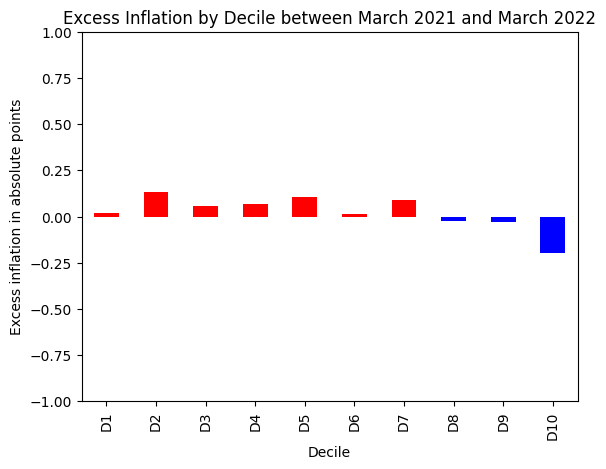

In [61]:
import matplotlib.pyplot as plt
# draw a bar chart

# define the custom ordering of the index values
custom_order = ['D{}'.format(i) for i in range(1, 11)]



# define the colors based on the value of each bar
colors = ['red' if x > 0 else 'blue' for x in sumAllThree['diffTOT_2022']]


sumAllThree.plot.bar(y='diffTOT_2022', color=colors)

# set axis labels and title
plt.xlabel('Decile')
plt.ylabel('Excess inflation in absolute points')
plt.title('Excess Inflation by Decile between March 2021 and March 2022')

# set the y-axis scale to a specific range
plt.ylim(-1,1)

# add a "D" prefix to the tick labels of the x-axis
ticks = ['D' + tick for tick in sumInflationMarch2022.index]
plt.xticks(range(len(ticks)), ticks)

# remove the legend entirely
plt.legend(frameon=False, labels=[])

# show the plot
plt.show()

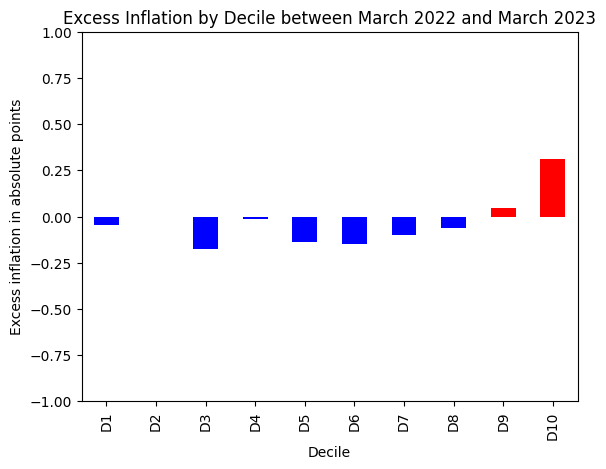

In [60]:
# define the colors based on the value of each bar
colors = ['red' if x > 0 else 'blue' for x in sumAllThree['diffTOT_2023']]


sumAllThree.plot.bar(y='diffTOT_2023', color=colors)

# set axis labels and title
plt.xlabel('Decile')
plt.ylabel('Excess inflation in absolute points')
plt.title('Excess Inflation by Decile between March 2022 and March 2023')

# set the y-axis scale to a specific range
plt.ylim(-1,1)

# add a "D" prefix to the tick labels of the x-axis
ticks = ['D' + tick for tick in sumInflationMarch2022.index]
plt.xticks(range(len(ticks)), ticks)

# remove the legend entirely
plt.legend(frameon=False, labels=[])

# show the plot
plt.show()

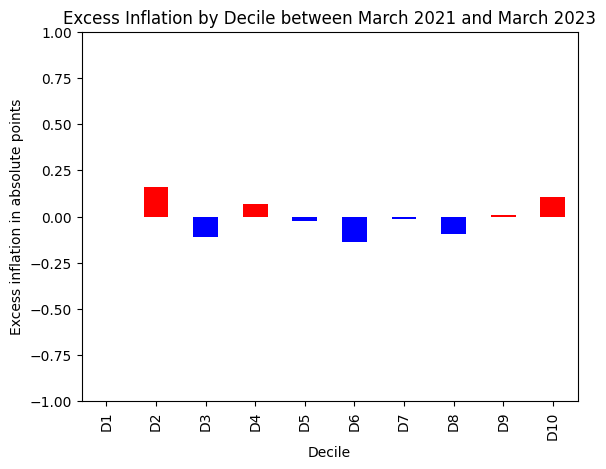

In [59]:
# define the colors based on the value of each bar
colors = ['red' if x > 0 else 'blue' for x in sumAllThree['diffTOT']]


sumAllThree.plot.bar(y='diffTOT', color=colors)

# set axis labels and title
plt.xlabel('Decile')
plt.ylabel('Excess inflation in absolute points')
plt.title('Excess Inflation by Decile between March 2021 and March 2023')

# set the y-axis scale to a specific range
plt.ylim(-1, 1)

# add a "D" prefix to the tick labels of the x-axis
ticks = ['D' + tick for tick in sumInflationMarch2022.index]
plt.xticks(range(len(ticks)), ticks)

# remove the legend entirely
plt.legend(frameon=False, labels=[])

# show the plot
plt.show()